[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ksachdeva/rethinking-tensorflow-probability/blob/master/notebooks/12_monsters_and_mixtures.ipynb)

# 12. Monsters and Mixtures

In [1]:
# Install packages that are not installed in colab
try:
  import google.colab
  !pip install -q watermark
  !pip install git+https://github.com/ksachdeva/rethinking-tensorflow-probability.git
except:
  pass

In [2]:
%load_ext watermark

In [3]:
# Core
import collections
import numpy as np
import arviz as az
import pandas as pd
import tensorflow as tf
import tensorflow_probability as tfp

# visualization 
import matplotlib.pyplot as plt

from rethinking.data import RethinkingDataset
from rethinking.data import dataframe_to_tensors
from rethinking.mcmc import sample_posterior


# aliases
tfd = tfp.distributions
tfb = tfp.bijectors
Root = tfd.JointDistributionCoroutine.Root

In [6]:
%watermark -p numpy,tensorflow,tensorflow_probability,arviz,scipy,pandas,rethinking

numpy                 : 1.21.5
tensorflow            : 2.7.0
tensorflow_probability: 0.15.0
arviz                 : 0.11.4
scipy                 : 1.7.3
pandas                : 1.3.5
rethinking            : 0.1.0



In [7]:
# config of various plotting libraries
%config InlineBackend.figure_format = 'retina'

## 12.1 Over-dispersed counts

### 12.1.1 Beta-binomial

##### Code 12.1


A beta distribution is a probability distribution for probabilities !

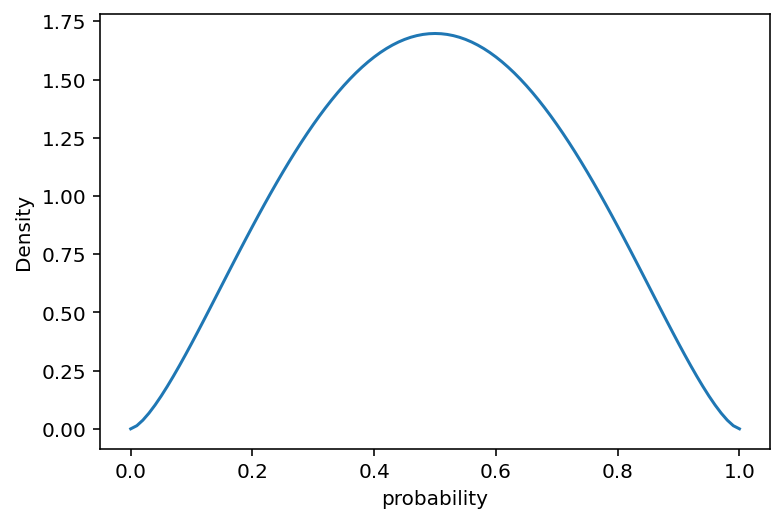

In [8]:
pbar = 0.5   # mean
theta = 5    # total concentration

alpha = pbar * theta
beta = (1 - pbar) * theta

x = np.linspace(0, 1, 101)

plt.plot(x, tf.exp(tfd.Beta(alpha, beta).log_prob(x)))
plt.gca().set(xlabel="probability", ylabel="Density");

##### Code 12.2

In [10]:
d = RethinkingDataset.UCBadmit.get_dataset()
d["gid"] = (d["applicant.gender"] != "male").astype(int)

In [11]:
tdf = dataframe_to_tensors("UCBAdmit", d, {
    "gid" : tf.int32,
    "applications" : tf.float32,
    "admit" : tf.float32,
    "reject" : tf.float32
})

In [12]:
def model_12_1(gid, N):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=0., scale=1.5), sample_shape=2))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      theta = phi + 2
      pbar = tf.sigmoid(tf.squeeze(tf.gather(alpha, gid, axis=-1)))        
        
      # prepare the concentration vector
      concentration1 = pbar * theta[...,tf.newaxis]
      concentration0 = (1 - pbar) * theta[...,tf.newaxis]    
    
      concentration = tf.stack([concentration1, concentration0], axis=-1)
        
      # outcome A i.e. admit  
      # since it is a multinomial we will have K = 2
      # note -  this does not really behave like Binomial in terms of the sample shape
      A = yield tfd.Independent(tfd.DirichletMultinomial(total_count=N, concentration=concentration), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=False)    
    
jdc_12_1 = model_12_1(tdf.gid, tdf.applications)

##### Code 12.3

In [13]:
# Prepare the expected shape by the DirichletMultinomial  
obs_values = tf.stack([tdf.admit, tdf.reject], axis=-1)

In [14]:
NUMBER_OF_CHAINS_12_1 = 2

init_state = [
    tf.zeros([NUMBER_OF_CHAINS_12_1, 2]),
    tf.ones([NUMBER_OF_CHAINS_12_1])
]

bijectors = [
    tfb.Identity(),
    tfb.Identity()
]


posterior_12_1, trace_12_1 = sample_posterior(
                                jdc_12_1, 
                                num_samples=1000,
                                observed_data=(obs_values,), 
                                init_state=init_state,
                                bijectors=bijectors,
                                params=['alpha', 'phi'])

In [15]:
# compute the difference between alphas
trace_12_1.posterior["da"] =  trace_12_1.posterior["alpha"][:,:,0] - \
         trace_12_1.posterior["alpha"][:,:,1]

# compute theta
trace_12_1.posterior["theta"] =  trace_12_1.posterior["phi"] + 2

In [16]:
az.summary(trace_12_1, hdi_prob=0.89)

,mean,sd,hdi_5.5%,hdi_94.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-0.439,0.418,-1.096,0.224,0.017,0.012,633.0,855.0,1.00
alpha[1],-0.334,0.409,-0.957,0.340,0.017,0.012,572.0,586.0,1.00
phi,0.769,1.018,-0.842,2.045,0.121,0.096,87.0,71.0,1.01
da,-0.105,0.565,-0.939,0.843,0.022,0.015,660.0,928.0,1.00
theta,2.769,1.018,1.158,4.045,0.121,0.092,87.0,71.0,1.01


##### Code 12.4

In [17]:
# Since we have two chains and data is stored in InferenceData format
# we have to manually extract it
#
# Here I am using the data from chain 0
sample_alpha = trace_12_1.posterior["alpha"][0,:].values
sample_theta = trace_12_1.posterior["theta"][0,:].values

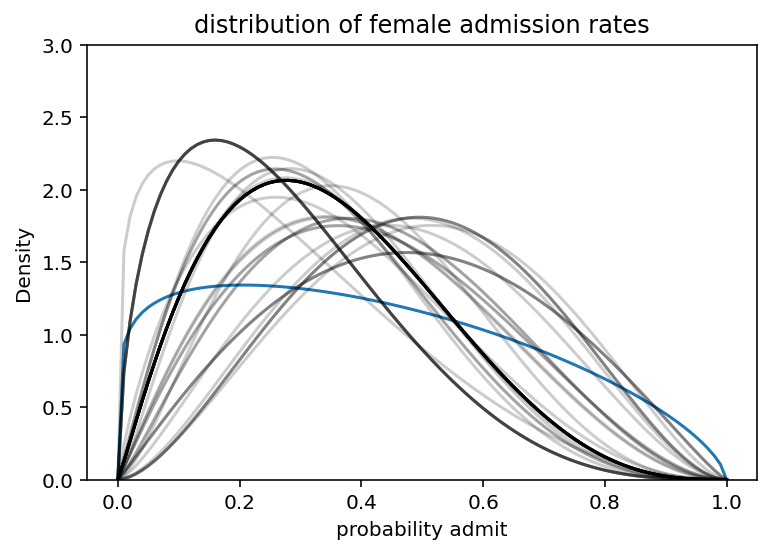

In [18]:
gid = 1
# draw posterior mean beta distribution
x = np.linspace(0, 1, 101)
pbar = tf.reduce_mean(tf.sigmoid(sample_alpha[:, gid]))
theta = tf.reduce_mean(sample_theta)
plt.plot(x, tf.exp(tfd.Beta(pbar * theta, (1 - pbar) * theta).log_prob(x)))
plt.gca().set(ylabel="Density", xlabel="probability admit", ylim=(0, 3));

# draw 50 beta distributions sampled from posterior
for i in range(50):
    p = tf.sigmoid(sample_alpha[i, gid])
    theta = sample_theta[i]
    plt.plot(x, tf.exp(tfd.Beta(p * theta, (1 - p) * theta).log_prob(x)),
             "k", alpha=0.2)
plt.title("distribution of female admission rates");

##### Code 12.5

In [19]:
# get samples given the posterior distribution
N = tf.cast(d.applications.values, dtype=tf.float32)
gid = d.gid.values

sample_pbar = tf.sigmoid(tf.squeeze(tf.gather(sample_alpha, gid, axis=-1)))    

# need to reshape it to make it happy
st = tf.reshape(sample_theta, shape=(1000,1))

# prepare the concentration vector
concentration1 = sample_pbar * st
concentration0 = (1 - sample_pbar) * st    

concentration = tf.stack([concentration1, concentration0], axis=-1)

dist = tfd.DirichletMultinomial(total_count=N, concentration=concentration)

predictive_samples = dist.sample()

In [20]:
# numpy style indexing magic ! .. hate it !
admit_rate = predictive_samples[::,::,0] / N

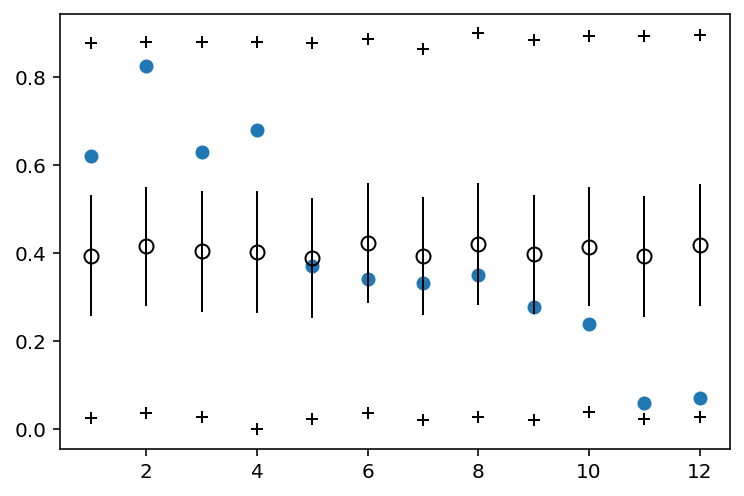

In [21]:
plt.scatter(range(1, 13), d.admit.values /N)
plt.errorbar(range(1, 13), np.mean(admit_rate, 0), np.std(admit_rate, 0) / 2,
             fmt="o", c="k", mfc="none", ms=7, elinewidth=1)
plt.plot(range(1, 13), np.percentile(admit_rate, 5.5, 0), "k+")
plt.plot(range(1, 13), np.percentile(admit_rate, 94.5, 0), "k+");

In the above plot, the vertifical axis shows the predicted proportion admitted, for each case on the horizontal.

Blue points show the empirical proportion admitted on each row of data

Open circles are the posterior mean pbar and + symbols mark the 89% interval of predicted counts of admission

### 12.1.2 Negative-binomial or gamma-Poisson

##### Code 12.6  (Not working !)

Start to use **Gamma-Poisson** (also known as **Negative Binomial**) models.

Essentially Gamm-Poisson is about associating a rate to each Posisson count observation. Estimates the shape of gamma distribution to describe the Poisson rates across cases.

Gamma-Poisson also expects more variation around the mean rate.

The negative binomial distribution arises naturally from a probability experiment of performing a series of independent Bernoulli trials until the occurrence of the rth success where r is a positive integer.

In [23]:
d = RethinkingDataset.Kline.get_dataset()
d["P"] = d.population.pipe(np.log).pipe(lambda x: (x - x.mean()) / x.std())
d["cid"] = (d.contact == "high").astype(int)

d.head()

,culture,population,contact,total_tools,mean_TU,P,cid
0,Malekula,1100,low,13,3.2,-1.291473,0
1,Tikopia,1500,low,22,4.7,-1.088551,0
2,Santa Cruz,3600,low,24,4.0,-0.515765,0
3,Yap,4791,high,43,5.0,-0.328773,1
4,Lau Fiji,7400,high,33,5.0,-0.044339,1


In [24]:
def model_12_2(cid, P):
    def _generator():      
      alpha = yield Root(tfd.Sample(tfd.Normal(loc=1., scale=1.), sample_shape=2))
      beta = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=2))
      gamma = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))
      phi = yield Root(tfd.Sample(tfd.Exponential(rate=1.), sample_shape=1))

      lambda_ = tf.exp(tf.squeeze(tf.gather(alpha, cid, axis=-1))) * \
              tf.math.pow(P, tf.squeeze(tf.gather(beta, cid, axis=-1))) / gamma
    
      g_concentration = lambda_ / phi
      g_rate = 1 / phi
    
      t1 = yield tfd.Independent(
          tfd.Gamma(concentration=g_concentration, rate=g_rate), reinterpreted_batch_ndims=1)
        
      T = yield tfd.Independent(tfd.Poisson(rate=t1), reinterpreted_batch_ndims=1)             
      
    return tfd.JointDistributionCoroutine(_generator, validate_args=True)    
    
jdc_12_2 = model_12_2(d.cid.values, tf.cast(d.P.values, dtype=tf.float32))

# Issue -
# Even prior sampling is not coming back !
# jdc_12_2.sample()

In [25]:
# NUMBER_OF_CHAINS_12_2 = 1

# alpha_init, beta_init, gamma_init, phi_init, t1_init, _ = jdc_12_2.sample(2)

# init_state = [
#     alpha_init,
#     beta_init,
#     gamma_init,
#     phi_init,
#     t1_init
# ]

# bijectors = [
#     tfb.Identity(),
#     tfb.Exp(),
#     tfb.Exp(),
#     tfb.Exp(),
#     tfb.Identity(),
# ]

# posterior_12_2, trace_12_2 = sample_posterior(jdc_12_2, 
#                                    observed_data=(d.total_tools.values,),
#                                    init_state=init_state,
#                                    bijectors=bijectors,
#                                    params=['alpha', 'beta', 'gamma' 'phi', 't1'])

In [26]:
# az.summary(trace_12_2, credible_interval=0.89)

## 12.2 Zero-inflated outcomes (TODO)

## 12.3 Ordered categorical outcomes (TODO)

## 12.4 Ordered categorical predictors (TODO)